In [1]:
import pandas as pd
import numpy as np

from google.colab import files
import io
import numpy.ma as ma
from scipy.spatial import distance as dist

from sklearn.neighbors import KDTree
import statistics as stats

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Aggregation
dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Aggregation.csv", encoding="ISO-8859-1" )
#Compound
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Compound.csv", encoding="ISO-8859-1" )
#D31
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/D31.csv", encoding="ISO-8859-1" )
#Flame
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Flame.csv", encoding="ISO-8859-1" )
#Jain
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Jain.csv", encoding="ISO-8859-1" )
#Pathbased
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Pathbased.csv", encoding="ISO-8859-1" )
#R15
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/R15.csv", encoding="ISO-8859-1" )
#Spiral
# dataset = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/Spiral.csv", encoding="ISO-8859-1" )

In [3]:
# Dataset com dados do artigo: (Sobre a etapa 5)
testando = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/datasets/teste.csv", encoding="ISO-8859-1" )

In [4]:
testando

,ordem,nc,a,b,fv
0,0,4,1.141320,1.80110,2.38908
1,1,8,0.918797,1.80110,3.15671
2,2,8,0.541373,1.55356,3.50071
3,3,8,0.541373,1.58024,3.13110
4,4,13,0.566252,1.59481,4.82690
...,...,...,...,...,...
783,783,18,0.360916,1.27136,5.39093
784,784,14,0.650650,1.65000,6.32439
785,785,13,0.500500,1.59572,4.47709
786,786,15,0.410395,1.37621,5.36319


# Etapa 1: Read and analyze data, and determine parameters

In [5]:
def etapa1(data):
  N = data.shape[0]
  alfa = 0.0
  alpha = 0.0
  beta = 0.0
  gama = 0.0

  for m in data:
    
    max_s = max(data[m])
    min_s = min(data[m])
    rs = max_s - min_s
    alfa += rs

  alpha = N/alfa
  beta = ((3.5 * alpha) + 45) / 100
  gama = ( (2 * alpha) + 18)/100
  k = max(10, (N * 0.01))
  
  return [N,alfa,alpha,beta,gama,k]

#Etapa 2: Construct k-D Tree: kDT

In [6]:
def etapa2(data):
  kdt = KDTree(data)
  return kdt

#Etapa 3: Searches kNN of sample, calculates mean of 5NN’s

In [7]:
def etapa3(data,N,kdt):
  distance = []
  knn_index = []
  d5nn = []

  distance, knn_index = kdt.query(data,N)

  for i in range(len(knn_index)):
    d5nn.append(np.mean(distance[i, 1:6]))

  print("KNN:")
  for i in range(N):
    print(distance[i][1],knn_index[i][1:16])

  return [distance, knn_index, d5nn]

#Etapa 4: Calculate the global radius of SR

In [8]:
def etapa4(d5nn):
  d5nn = np.sort(d5nn)
  R = max(d5nn)
  print("R:",R)
  return [d5nn, R]

#Etapa 5: Calculate sample density array(Rho)

In [9]:
def fab(i,j,a,b,distance):
  d = distance[i,j]
  if d >= 0 and d<= a:
    return 1
  elif d > a and d <= b:
    return ((b-d)/ (b-a))
  elif d > b:
    return 0

In [10]:
def etapa5(N,R,distance):
  surrounding_region = []
  Rho = []
  for i in range(N):
    Rho.append(0)

  for i in range(N):
    surrounding_region = distance[i,] < R
    surrounding_region = distance[i,surrounding_region]
    surrounding_mean = np.mean(surrounding_region)
    surrounding_std_dev = stats.stdev(surrounding_region)
    surrounding_region = np.sort(surrounding_region)

    nc = len(surrounding_region)

    d1 = np.mean(surrounding_region[:(np.int(np.ceil(nc*0.1))+1)])
    d2 = min(surrounding_region[1:])

    a = (d1+d2)/2
    b = min((a+(2*surrounding_std_dev)),R)

    # a = testando.a[i]
    # b = testando.b[i]

    for j in range(0,len(surrounding_region)):
      f = fab(i,j,a,b, distance)
      Rho[i] += f

    print(i, "nc:",nc, " a: %.5f"  %a, " b: %.5f"%b, " Rho: %.5f" %Rho[i])
  return [surrounding_region, Rho]

#Etapa 6: Calculate the global density threshold(T)

In [11]:
def etapa6(N,rho):
  arr = []
  for i in range(N):
    arr.append((rho[i], i))

  arr.sort()
  arr_invert = arr[::-1]

  df_arr = pd.DataFrame(arr_invert)
  t = np.percentile(df_arr[0], 25)

  print("T:",t)
  return [t,arr_invert]

#Etapa 7: Clustering

In [12]:
def existe(arr, valor):
  for i in arr:
    if i == valor:
      return True
  return False

In [13]:
# Feito 2 queue para registrar que já passou por determinada amostra, se não, entra em loop infinito
def etapa7(N,R,arr,t,rho,k,knn_index,distance,beta,gama ):
  order_of_cluster = 0
  tag = []
  for i in range(N):
    tag.append(False)
  queue = []
  queue_2 = []

  result = []
  for y in range(N):
    result.append(0)

  for ind in range(N):
    # 1 representa indice e 0 valor de arr
    if ( tag[np.int(arr[ind][1])]):
      continue
    if (arr[ind][0] == 0):
      tag[np.int(arr[ind][1])] = True
      continue
    if ( arr[ind][0] < t ):
      continue

    order_of_cluster += 1
    tag[ np.int(arr[ind][1]) ] = True
    queue.clear()
    queue_2.clear()
    queue.append(arr[ind][1])
    queue_2.append(arr[ind][1])

    while (len(queue) > 0):
      i = queue.pop(0)

      aver = (R + rho[np.int(i)]) / 2
      local_t = aver * beta

      for e in range(k):
        j = knn_index[np.int(i)][e]

        if (distance[np.int(i)][e] > R):
          continue
        
        co_nn = 0
        for a in range(1,k):
          for b in range(1,k):
            if (knn_index[np.int(i)][a] == knn_index[j][b]):
              co_nn += 1

        tag[j] = True

        if (rho[j]):
          result[j] = order_of_cluster 
          if (rho[j] >= local_t and co_nn > (k * gama)):   #(Rho[j] > = localT && co_NN > k ∗γ )

            if (not existe(queue_2,j)):
              queue.append(j)
              queue_2.append(j)
              # print(j)

  # print("Resultado parcial:",result)

  return [result,order_of_cluster]

#Etapa 8: Post–Process clustering and save the results

In [14]:
def etapa8(N,order_of_cluster,result):

  for cluster in range(1,order_of_cluster):
    cont = 0
    for i in result:
      if (i == cluster):
        cont += 1

    if ( cont <= 5 ):
      for j in range(N):
        if (result[j] == cluster ):
          result[j] = 0

  resultLenToPrint = np.int(np.ceil((len(result)/10)))
  for i in range(resultLenToPrint):
    print(i*10,end=" ")
    if i == (resultLenToPrint-1):
      for j in range(len(result)%10):
        print(result[( (i*10) + j )],end=" ")
    else:
      for j in range(10):
        print(result[( (i*10) + j )],end=" ")
    print(" ")

  return result

Plot dos gráficos

In [15]:
def plotar(data, out):
  g =sns.scatterplot(x="d1", y="d2",
                hue=out,palette ="Paired",
                data=data)
  plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
  plt.show()

In [16]:
def plotarGraficos(data_in, out_acnd, out_origin):
  plotar(data_in,out_origin)
  plotar(data_in,out_acnd)

# Função do algoritmo:

In [17]:
def acnd(dataset):
  data = dataset[['d1','d2']]
  saida = dataset['cluster']
  N,alfa,alpha,beta,gama,k = etapa1(data)
  # print([N,alfa,alpha,beta,gama,k])

  kdt = etapa2(data)
  # print(kdt)

  distance,knn_index,d5nn = etapa3(data, N, kdt)
  # print(distance)

  d5nn, R = etapa4(d5nn)
  # print(R)

  surrounding_region, Rho = etapa5(N,R,distance)
  # print(rho)
  # Rho = testando.fv

  T,Arr = etapa6(N,Rho)
  # print(T)
  result, order_clusters = etapa7(N,R,Arr,T,Rho,k,knn_index,distance,beta,gama)

  result = etapa8(N,order_clusters,result)

  plotarGraficos(data,result,saida)

KNN:
1.1401754250991385 [ 2  1  3  4  5  7  6  8  9 10 11 12 15 14 16]
0.9178779875342921 [ 2  4  0  7  3  8  5  9 15  6 10 14 11 13 12]
0.5408326913195972 [ 3  4  1  5  0  7  6  9  8 10 11 12 15 14 16]
0.5408326913195972 [ 2  4  5  6  0  1  7 11 12  9 10  8 15 17 16]
0.5656854249492372 [ 5  7  2  3  9  1  6 10 11  8 12 15  0 16 14]
0.5656854249492372 [ 4  6  3  7 11  2 10 12  9  1  8 15 17 16  0]
0.7826237921249256 [ 5 12 11  3  4 10  2  7  9 18 17 16 19  1  0]
0.6264982043070844 [ 4  9  5  8 10 15  2  1 11  3 14 16 12  6 25]
0.6999999999999993 [15 14  7  9 13  4  1 10 16 25  5  2 26 27 11]
0.6403124237432851 [10  7 15 16 11  8  4  5 14 12 25 19 17  6 26]
0.5590169943749446 [11  9 12 16 17  7  5 19  4  6 15 18 25 20  8]
0.26925824035672574 [12 10  6 17  5  9 18 19  7 16  4 20 21  3 15]
0.26925824035672574 [11 10  6 18 17  5  9 19  4 16  7 21 20  3 15]
0.9617692030835658 [ 14  28   8  15  27  29  26  25 131  30   9   7  16 132 130]
0.5522680508593636 [15  8 13 25 26 27  9 16  7 29 28 1

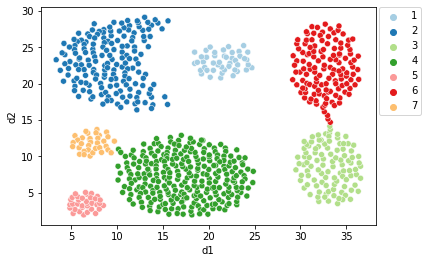

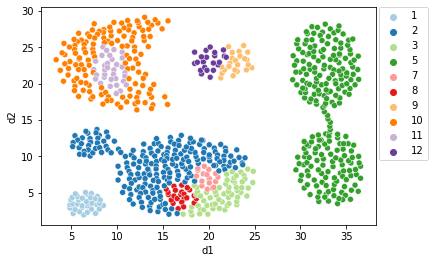

In [19]:
acnd(dataset)

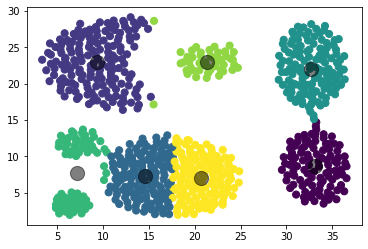

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(dataset)
y_kmeans = kmeans.predict(dataset)

plt.scatter(dataset['d1'],dataset['d2'], c =y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

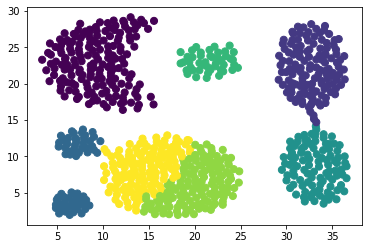

In [66]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=7,threshold=0.5)
brc.fit(dataset)
y_brc = brc.predict(dataset)

plt.scatter(dataset['d1'],dataset['d2'],c=y_brc,s=50, cmap='viridis')

#centers = brc.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

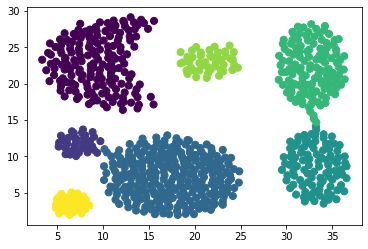

In [91]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2, min_samples=2).fit_predict(dataset)
plt.scatter(dataset['d1'],dataset['d2'],c=clustering,s=50, cmap='viridis')
#y_clus = clustering.predict(dataset)